Step 3. Run a multi-scenario optimization for GHG vs. generation-side charges.

This process creates SimulationOptimization and MultiScenarioOptimization objects in http://localhost:8000/admin/optimization/ along with associated DER simulations and cost calculations.

In [1]:
import os, sys
PWD = os.getenv('PWD')
os.chdir(PWD)
sys.path.insert(0, os.getenv('PWD'))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()

In [2]:
from datetime import datetime, timedelta

from beo_datastore.libs.battery import Battery
from beo_datastore.libs.battery_schedule import create_fixed_schedule, optimize_battery_schedule
from beo_datastore.libs.plot_intervalframe import (
        plot_frame288, plot_frame288_monthly_comparison, plot_intervalframe, plot_many_frame288s
)

from cost.ghg.models import GHGRate
from cost.optimization.models import MultiScenarioOptimization, SimulationOptimization
from cost.utility_rate.models import RatePlan
from der.simulation.models import BatteryConfiguration, BatteryStrategy
from load.customer.models import CustomerCluster

See http://localhost:8888/notebooks/demo/1_create_kmeans_clusters.ipynb to create CustomerClusters and http://localhost:8888/notebooks/demo/2_create_battery_and_battery_schdule.ipynb to create BatteryConfigurations and BatterySchedules.

In [3]:
# the following steps can be also performed via Django admin at http://localhost:8000/admin/optimization/

# create multi-scenario optimization
multi = MultiScenarioOptimization.objects.create()

# create simulation optimizations and add them to a multi-scenario optimization
for config in [BatteryConfiguration.objects.first()]:
    for strategy in [BatteryStrategy.objects.get(id=1), BatteryStrategy.objects.get(id=2)]:
        single, _ = SimulationOptimization.objects.get_or_create(
            start=datetime(2018, 1, 1),
            end_limit=datetime(2019, 1, 1),
            battery_strategy=strategy,
            battery_configuration=config,
            rate_plan=RatePlan.objects.get(name__contains="A6"),
        )
        single.customer_clusters.add(CustomerCluster.objects.first())
        single.ghg_rates.add(*GHGRate.objects.filter(name="Clean Net Short"))
        single.ghg_rates.add(*GHGRate.objects.filter(name="CARB - Unspecified Power"))
        multi.simulation_optimizations.add(single)

In [4]:
# as an alternative, you can retrieve an existing multi-scenario optimization
# multi = MultiScenarioOptimization.objects.get(id=1)

In [5]:
# this step kicks off all battery simulations and cost calculations
multi.run(multiprocess=True)

In [6]:
# display all bill and GHG impacts from every single simulation optimization
display(multi.detailed_report)

,BillDelta,CleanNetShort2018Delta,CleanNetShort2022Delta,CleanNetShort2026Delta,CleanNetShort2030Delta,CARB-UnspecifiedPower2013Delta,SimulationOptimization,BatteryConfiguration,BatteryStrategy,SimulationRatePlan,MeterRatePlan
SA_ID,,,,,,,,,,,
7,-44.761028,0.242337,-0.024578,0.028445,-0.597213,0.297063,5,120kW @ 4 hours (90.0% efficiency),Minimize using EV energy weekend with 0kW thre...,"A6, Small General Service with TOU",A6
7,584.775006,0.286388,-0.619407,-0.231627,-1.829728,0.352910,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",A6
14,133.296547,0.912361,-4.323985,-3.033547,-7.450765,1.294491,5,120kW @ 4 hours (90.0% efficiency),Minimize using EV energy weekend with 0kW thre...,"A6, Small General Service with TOU",A6
14,3662.264774,2.063940,-16.312789,-11.615707,-27.796632,4.082138,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",A6
21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,120kW @ 4 hours (90.0% efficiency),Minimize using EV energy weekend with 0kW thre...,"A6, Small General Service with TOU",A6
21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",A6
30,-40.964670,0.315576,-0.353163,-0.176987,-1.148352,0.405426,5,120kW @ 4 hours (90.0% efficiency),Minimize using EV energy weekend with 0kW thre...,"A6, Small General Service with TOU",A6
30,633.879252,0.340602,-1.948537,-1.350901,-3.471023,0.571275,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",A6
46,150.788758,0.231861,-0.098044,0.058210,-0.360770,0.277465,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",A6


In [7]:
# this step can be run using different filtering criteria

# remove all existing filters
multi.initialize()

# filter simulations
multi.filter_by_query("CleanNetShort2030Delta < -1")  # include only CleanNetShort2030Delta < -1
multi.filter_by_transform("CleanNetShort2030Delta", min)  # limit results to min CleanNetShort2030Delta values 

In [8]:
# display bill and GHG impacts
display(multi.detailed_report)

,SimulationOptimization,BatteryConfiguration,BatteryStrategy,SimulationRatePlan,BillDelta,CleanNetShort2018Delta,CleanNetShort2022Delta,CleanNetShort2026Delta,CleanNetShort2030Delta,CARB-UnspecifiedPower2013Delta,MeterRatePlan
7,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",584.775006,0.286388,-0.619407,-0.231627,-1.829728,0.352910,A6
14,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",3662.264774,2.063940,-16.312789,-11.615707,-27.796632,4.082138,A6
30,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",633.879252,0.340602,-1.948537,-1.350901,-3.471023,0.571275,A6
83,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",623.761142,0.290071,-4.074290,-3.824237,-5.612891,0.741846,A6
87,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",191.769618,1.019697,-4.836754,-3.271171,-10.005043,1.651606,A6
5010,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",2060.954264,0.928228,-6.153591,-4.099474,-11.280315,1.849484,A6
5067,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",1031.662581,0.909480,-2.207679,-0.821427,-6.173441,1.120391,A6
5086,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",2607.483256,1.054646,-7.455612,-5.391405,-13.018153,2.093355,A6
5090,6,120kW @ 4 hours (90.0% efficiency),Minimize using Clean Net Short 2030 with 0kW t...,"A6, Small General Service with TOU",935.949170,0.438824,-1.410247,-1.198243,-3.256815,0.706395,A6


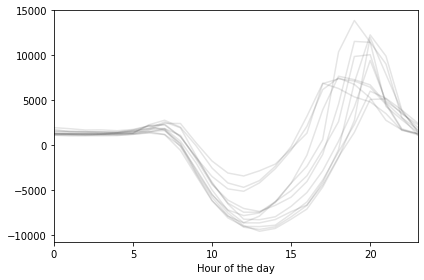

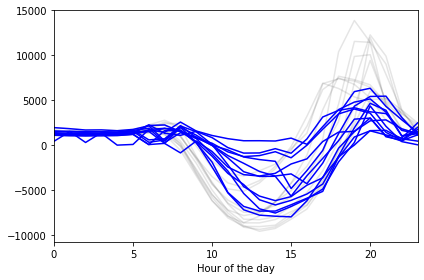

In [9]:
# plot all meters in study (combined into a single load profile)
frame288_type = "total_frame288"

# plot all meters combined before battery
plot_frame288(multi.pre_DER_intervalframe.total_frame288)
# compare all meteres combined after battery with before battery
plot_many_frame288s(
    [getattr(multi.post_DER_intervalframe, frame288_type)],
    getattr(multi.post_DER_intervalframe, frame288_type),
)

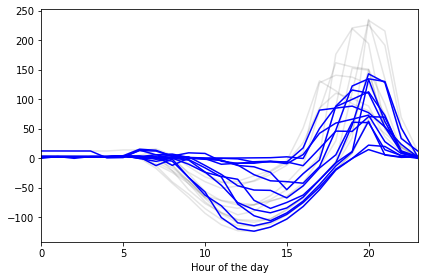

None

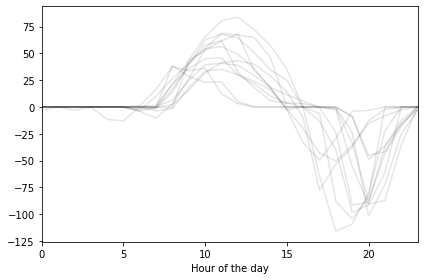

None

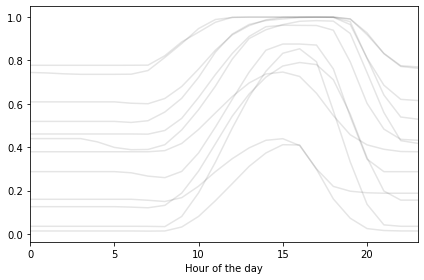

None

In [10]:
sa_id = 14

# examine battery operations for a single meter
battery_simulation = multi.battery_simulations.get(meter__sa_id=sa_id)

# display average daily load before battery
display(plot_many_frame288s(
    [battery_simulation.pre_intervalframe.average_frame288],
    battery_simulation.post_intervalframe.average_frame288
))

# display average battery discharge
display(plot_frame288(battery_simulation.intervalframe.average_frame288))

# display average battery state of charge
display(plot_frame288(battery_simulation.average_state_of_charge_frame288))

In [11]:
# view individual before and after bills
bill_calculation = multi.bill_calculations.get(battery_simulation__meter__sa_id=sa_id)
bill_comparison = bill_calculation.bill_comparisons.get(start=datetime(2018, 7, 1))

display(bill_comparison.pre_DER_validation_bill.total_dataframe)
display(bill_comparison.post_DER_validation_bill.total_dataframe)

,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge - Summer Peak,0,-12351.600,kWh,0.34,$/kWh,1,-4199.544000
1,energy,Energy Charge - Summer Part-Peak,1,-4848.696,kWh,0.102,$/kWh,1,-494.566992
2,energy,Energy Charge - Summer Off-Peak,2,-5424.468,kWh,0.045,$/kWh,1,-244.101060
Total,,,,-22624.764,,,,,-4938.212052


,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge - Summer Peak,0,-12198.266667,kWh,0.34,$/kWh,1,-4147.410667
1,energy,Energy Charge - Summer Part-Peak,1,-3294.862667,kWh,0.102,$/kWh,1,-336.075992
2,energy,Energy Charge - Summer Off-Peak,2,-6873.690222,kWh,0.045,$/kWh,1,-309.316060
Total,,,,-22366.819556,,,,,-4792.802719


In [12]:
# view individual before and after monthly GHG emissions
ghg_calculation = multi.ghg_calculations.get(battery_simulation__meter__sa_id=sa_id, ghg_rate__name="Clean Net Short", ghg_rate__effective__year=2030)
display(ghg_calculation.aggregate_ghg_calculation.comparison_table)

,before,after
1,6.991316,5.404074
2,6.899589,2.692434
3,8.392276,5.067767
4,7.730288,4.216619
5,2.819063,0.228841
6,-0.054740,-1.322555
7,-1.173558,-2.483096
8,-0.846817,-2.516740
9,1.000247,-0.606948
10,7.095760,3.731680
